In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicProvider
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
from pylatexenc import *
from qiskit.circuit.library import QFT
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt
import math
from scipy.optimize import curve_fit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from qiskit import pulse                 
from qiskit.circuit import Parameter, Gate
import qiskit_ibm_provider
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_provider.job import job_monitor
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit.transpiler import Layout

/var/folders/h3/mc63pl7x7kb9s61dxd7795jc0000gn/T/ipykernel_53459/1620831284.py:18: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  import qiskit_ibm_provider


In [2]:
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="999e14a533a70658d88ba22c2b21691e16596147bb012cb26fcaa1aba4212f236c0445bef5a8df0648de4adbeb2048db94855ba9d1e9b0c57ed998d13c87cf97",overwrite=True)

In [3]:
# # Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

In [4]:
# Choose your backend
provider = IBMProvider()
backend_name = 'ibm_brisbane'
backend = provider.get_backend(backend_name)

backend_defaults = backend.defaults()

backend_properties = backend.properties()

In [5]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze

default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

default_anharmonicity = backend_properties.qubits[qubit][3].value # Default anharmonicity in GHz
print(f"Default anharmonicity is {default_anharmonicity} GHz.")

# scale data (specific to each device)
scale_factor = 1e-7

# number of shots for our experiments
NUM_SHOTS = 1024

Qubit 0 has an estimated frequency of 4.721905422832827 GHz.
Default anharmonicity is -0.31197865973435573 GHz.


In [6]:
# there are pulse parameters of the single qubit drive in IBM devices
x12_duration = 160
x12_sigma = 40

In [8]:
# ########discriminating states
# #######################

# ####Computing the 1->2 frequency
# ##Excite the |1⟩ state by applying a 0 -> 1 π pulse. Then perform the frequency sweep over excitations of the |1⟩ state. 
# ##A single peak should be observed at a frequency lower than the 0 -> 1 frequency which corresponds to the 1 -> 2 frequency.
# # smaller range sweep
# num_freqs = 75
# drive_power = 0.15
# sweep_freqs = default_anharmonicity*GHz + np.linspace(-40*MHz, 40*MHz, num_freqs)

# freq = Parameter('freq')
# with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as freq12_sweep_sched:
#     drive_chan = pulse.drive_channel(qubit)
#     with pulse.frequency_offset(freq, drive_chan):
#         pulse.play(pulse.Gaussian(duration=x12_duration,
#                                   amp=drive_power,
#                                   sigma=x12_sigma,
#                                   name='x12_pulse'), drive_chan)

# spect_gate = Gate("spect", 1, [freq])

# qc_spect = QuantumCircuit(3, 3)

# qc_spect.x(2)
# qc_spect.append(spect_gate, [2])
# qc_spect.measure(2, 2)
# qc_spect.add_calibration(spect_gate, (2,), freq12_sweep_sched, [freq])
    
# exp_spect_circs = [qc_spect.assign_parameters({freq: f}) for f in sweep_freqs]

# excited_freq_sweep_job = backend.run(exp_spect_circs, 
#                                      meas_level=1, 
#                                      meas_return='avg', 
#                                      shots=NUM_SHOTS)
# excited_freq_sweep_job.job_id()

# ### job_monitor(excited_freq_sweep_job)

# # # [-30, 30]
# # job_id = "cv598m2qxmm00085dvwg"
# # excited_freq_sweep_job = service.job(job_id)

# # ## [-100, 100]
# # # job_id = "cv599v7x55b0008qww7g"
# # # excited_freq_sweep_job = service.job(job_id)

# # [-40, 40]
# job_id = "cv59cqax55b0008qww90"
# excited_freq_sweep_job = service.job(job_id)



# # Get the refined data (average)
# # plot and fit the refined signal, using the standard Lorentzian curve.
# excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)
# excited_sweep_freqs = default_qubit_freq + default_anharmonicity*GHz + np.linspace(-40*MHz, 40*MHz, num_freqs)

# def fit_function(x_values, y_values, function, init_params):
#     """Fit a function using scipy curve_fit."""
#     fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev = 50000)
#     y_fit = function(x_values, *fitparams)
    
#     return fitparams, y_fit

# ##do fit in Hz
# (excited_sweep_fit_params, 
#  excited_sweep_y_fit) = fit_function(excited_sweep_freqs,
#                                      excited_freq_sweep_data, 
#                                      lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
#                                      [-20, 4.609661814854965*GHz, 0.06*GHz, 3*GHz] # initial parameters for curve_fit
#                                      )

# # Note: we are only plotting the real part of the signal
# plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
# plt.plot(excited_sweep_freqs/GHz, excited_sweep_y_fit, color='red')
# plt.xlim([min(excited_sweep_freqs/GHz), max(excited_sweep_freqs/GHz)])
# plt.xlabel("Frequency [GHz]", fontsize=15)
# plt.ylabel("Measured Signal [a.u.]", fontsize=15)
# plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
# plt.show()
# # plt.savefig('DATA frequency sweep.pdf')

# _, qubit_12_freq, _, _ = excited_sweep_fit_params
# print(f"Our updated estimate for the 1->2 transition frequency is "
#       f"{round(qubit_12_freq/GHz, 7)} GHz.")

In [9]:
# #######1->2 Rabi Experiment
# ##############################
# ##perform a Rabi experiment to obtain the π pulse amplitude for the 1 -> 2 transition.
# ##To do so, we apply a 0 → 1 π pulse and then sweep over drive amplitudes at the 1 -> 2 frequency.

# # experimental configuration
# num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# # Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
# drive_amp_min = 0
# drive_amp_max = 1.0
# drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

# amp = Parameter('amp')
# with pulse.build(backend=backend, default_alignment='sequential', name='Amp sweep') as rabi_sched:
#     drive_chan = pulse.drive_channel(qubit)
#     pulse.set_frequency(qubit_12_freq, drive_chan)
#     pulse.play(pulse.Gaussian(duration=x12_duration,
#                               amp=amp,
#                               sigma=x12_sigma,
#                               name='x12_pulse'), drive_chan)
    
# rabi_gate = Gate("rabi", 1, [amp])

# qc_rabi = QuantumCircuit(3, 3)

# qc_rabi.x(2)
# qc_rabi.append(rabi_gate, [2])
# qc_rabi.measure(2, 2)
# qc_rabi.add_calibration(rabi_gate, (2,), rabi_sched, [amp])
    
# exp_rabi_circs = [qc_rabi.assign_parameters({amp: a}) for a in drive_amps]

# # rabi_12_job = backend.run(exp_rabi_circs, 
# #                           meas_level=1, 
# #                           meas_return='avg', 
# #                           shots=NUM_SHOTS)

# # rabi_12_job.job_id()

In [10]:
# # ## Get the job data (average)
# # job_id = "cv59daxx55b0008qwwa0"
# # rabi_12_job = service.job(job_id)

# job_id = "cv59grbhdzz0008m33fg"
# rabi_12_job = service.job(job_id)


# rabi_12_data = get_job_data(rabi_12_job, average=True)

# def baseline_remove(values):
#     """Center data around 0."""
#     return np.array(values) - np.mean(values)

# # Note: Only real part of data is plotted
# rabi_12_data = np.real(baseline_remove(rabi_12_data))
# (rabi_12_fit_params, 
#  rabi_12_y_fit) = fit_function(drive_amps,
#                                rabi_12_data, 
#                                lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
#                                [0.2, 0, 0.3, 0])

# plt.scatter(drive_amps, rabi_12_data, color='black')
# plt.plot(drive_amps, rabi_12_y_fit, color='red')

# drive_12_period = rabi_12_fit_params[2] 

# pi_amp_12 = drive_12_period/2

# plt.axvline(pi_amp_12, color='red', linestyle='--')
# plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
# plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
# plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

# plt.xlabel("Drive amp [a.u.]", fontsize=15)
# plt.ylabel("Measured signal [a.u.]", fontsize=15)
# plt.title('Rabi Experiment (1->2)', fontsize=20)
# plt.show()

# print(f"Our updated estimate for the 1->2 transition frequency is "
#       f"{round(qubit_12_freq/GHz, 7)} GHz.")
# print(f"Pi Amplitude (1->2) = {pi_amp_12}")

In [7]:
n_a = 1 ## ancilla
n_a_new = 1  ## new ancilla for defense
n_l = 2 ## clock register
n_b = 1 ## input vector

In [8]:
qubit_12_freq = 4409711500
pi_amp_12 = 0.2466186343423263

In [9]:
## Build 1->2 pulse
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)
x12_gate = Gate("one_two_pulse", 1, [])

In [14]:
# test = QuantumCircuit(3, 3)

# # test.x(2)
# # test.append(x12_gate, [2])
# test.measure(2, 2)
# # test.add_calibration(x12_gate, (2,), x12_sched, [])
# test_tr = transpile(test, backend, layout_method='trivial')
# # test_tr.draw()

In [15]:
# job = backend.run(test_tr, 
#                   meas_level=1, 
#                   meas_return='single', 
#                   shots=1024)
# job.job_id()

In [16]:
# job_monitor(job)

In [17]:
# job_id = "cv5w9fxhdzz0008m4vj0"
# job = service.job(job_id)
# result = job.result()
# counts = result.get_counts()
# plot_histogram(counts)

In [18]:
# job_id = "cv5wf2wx55b0008qypb0"
# IQ_2_job = service.job(job_id)
# two_data = get_job_data(IQ_2_job, average=False)

# job_id = "cv5wfszfkm5g008bxfb0"
# IQ_1_job = service.job(job_id)
# one_data = get_job_data(IQ_1_job, average=False)

# job_id = "cv5wg6g12hg0008wjre0"
# IQ_0_job = service.job(job_id)
# zero_data = get_job_data(IQ_0_job, average=False)

# def IQ_012_plot(x_min, x_max, y_min, y_max):
#     """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
#     as arguments."""
#     # # zero data plotted in blue
#     plt.scatter(np.real(zero_data), np.imag(zero_data), 
#                     s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
#     # one data plotted in red
#     plt.scatter(np.real(one_data), np.imag(one_data), 
#                     s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
#     # two data plotted in green
#     plt.scatter(np.real(two_data), np.imag(two_data), 
#                     s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

#     # Plot a large dot for the average result of the 0, 1 and 2 states.
#     mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
#     mean_one = np.mean(one_data)
#     mean_two = np.mean(two_data)
#     plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
#                 s=200, cmap='viridis', c='black',alpha=1.0)
#     plt.scatter(np.real(mean_one), np.imag(mean_one), 
#                 s=200, cmap='viridis', c='black',alpha=1.0)
#     plt.scatter(np.real(mean_two), np.imag(mean_two), 
#                 s=200, cmap='viridis', c='black',alpha=1.0)
    
#     plt.xlim(x_min, x_max)
#     plt.ylim(y_min,y_max)
#     plt.legend()
#     plt.ylabel('I [a.u.]', fontsize=15)
#     plt.xlabel('Q [a.u.]', fontsize=15)
#     plt.title("0-1-2 discrimination", fontsize=15)
    
# x_min = -100
# x_max = 100
# y_min = -50
# y_max = 300
# IQ_012_plot(x_min, x_max, y_min, y_max)

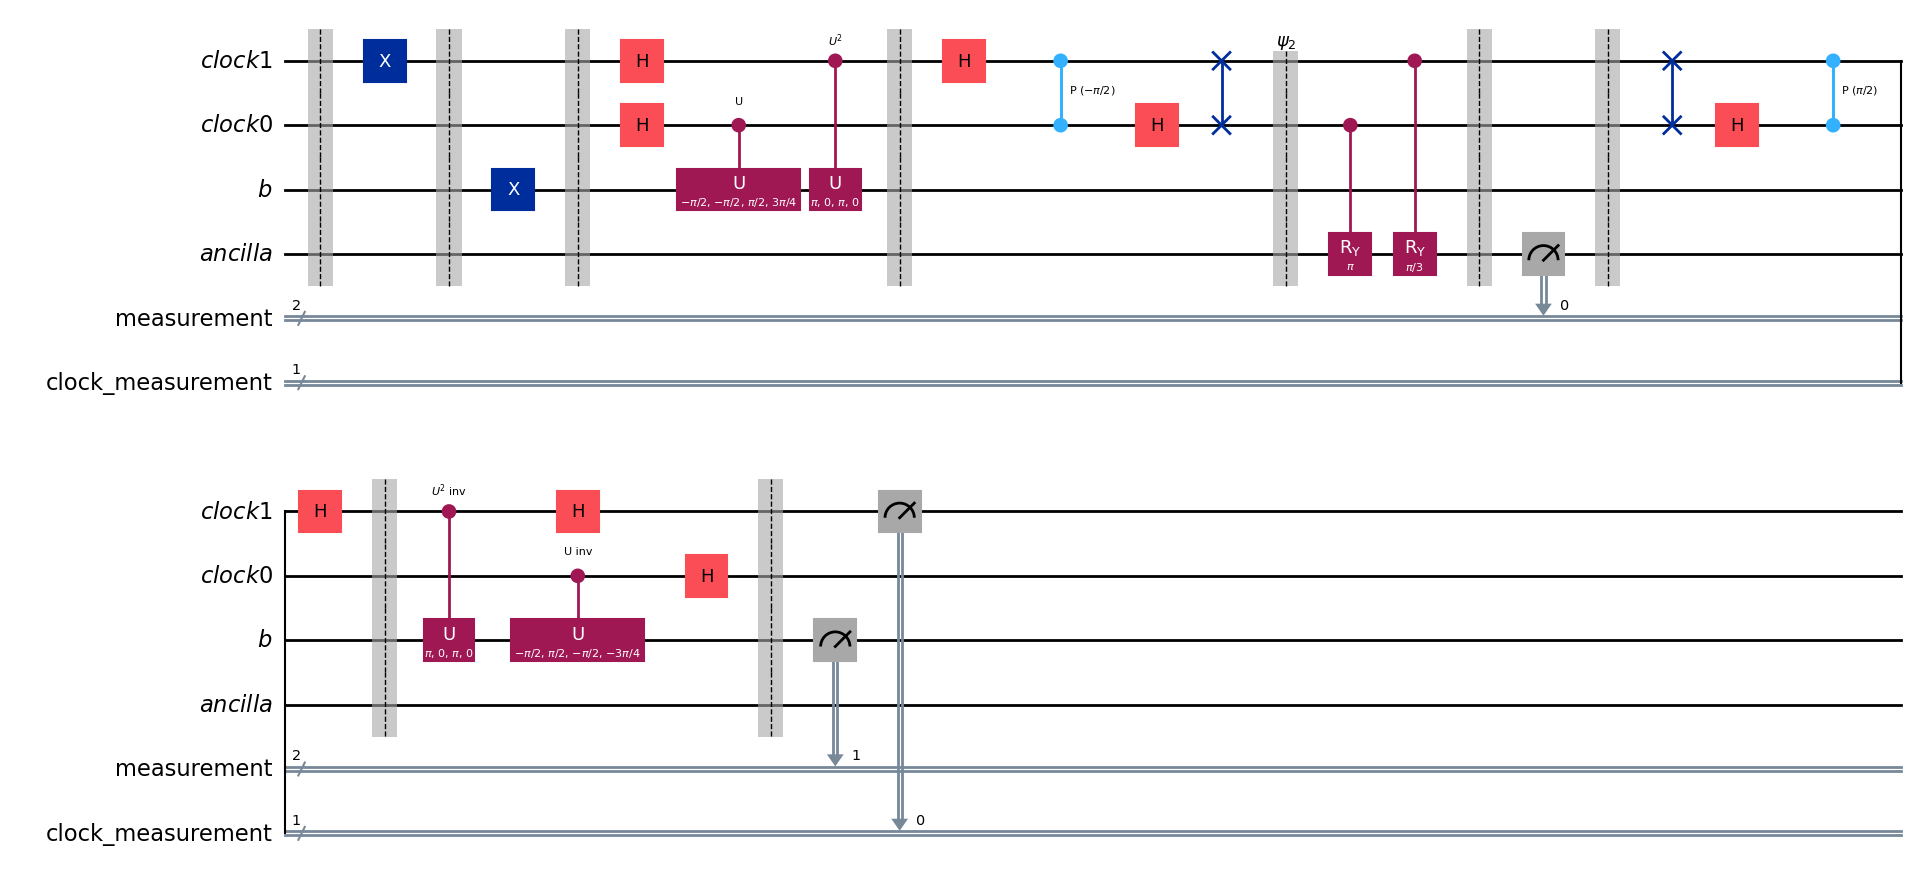

In [79]:
# Defense for clock
ancilla = QuantumRegister(n_a, name='ancilla')
# clock = QuantumRegister(n_l, name='clock')
clock0 = QuantumRegister(1, name='clock0')
clock1 = QuantumRegister(1, name='clock1')
b = QuantumRegister(n_b, name='b')
measurement = ClassicalRegister(2, name='measurement')
c_measurement = ClassicalRegister(1, name='clock_measurement')


initial_layout = [0, 1, 2, 3]

# hhl = QuantumCircuit(b, clock, ancilla, measurement)
hhl = QuantumCircuit(clock1, clock0, b, ancilla, measurement, c_measurement)

hhl.barrier()


hhl.x(clock1)
# hhl.append(x12_gate, [0])
# hhl.add_calibration(x12_gate, (0,), x12_sched, [])

hhl.barrier()
hhl.x(b)
hhl.barrier()
hhl.h(clock0)
hhl.h(clock1)
hhl.cu(-pi/2, -pi/2, pi/2, 3/4*pi, clock0, b, label='U')
hhl.cu(pi, 0, pi, 0, clock1, b, label=r'$U^2$')
hhl.barrier()
hhl.h(clock1)
hhl.cp(-np.pi/2, clock0, clock1)
hhl.h(clock0)
hhl.swap(clock0, clock1)
hhl.barrier(label='$\psi_2$')
hhl.cry(pi, clock0, ancilla)
hhl.cry(pi/3, clock1, ancilla)
hhl.barrier()
hhl.measure(ancilla, measurement[0])
hhl.barrier()
hhl.swap(clock0, clock1)
hhl.h(clock0)
hhl.cp(np.pi/2, clock0, clock1)
hhl.h(clock1)
hhl.barrier()
hhl.cu(pi, 0, pi, 0, clock1, b, label=r'$U^2$ inv')
hhl.cu(-pi/2, pi/2, -pi/2, -3/4*pi, clock0, b, label='U inv')
hhl.h(clock0)
hhl.h(clock1)
hhl.barrier()
hhl.measure(b,measurement[1])
hhl.measure(clock1, c_measurement)

hhl.draw("mpl")

In [91]:
####### Defense for ancilla

# ancilla = QuantumRegister(n_a, name='ancilla')
# new_ancilla = QuantumRegister(n_a_new, name='new_ancilla')
# b = QuantumRegister(n_b, name='b')
# clock = QuantumRegister(n_l, name='clock')
# ancilla_measurement = ClassicalRegister(2, name='c_ancilla')
# b_measurement = ClassicalRegister(1, name='c_b')

# hhl = QuantumCircuit(new_ancilla, ancilla, clock, b, ancilla_measurement, b_measurement)
# initial_layout = [0, 14, 1, 2, 3]

# hhl.barrier()
# ##### attack area

# hhl.x(new_ancilla)
# # hhl.append(x12_gate, [0])
# # hhl.add_calibration(x12_gate, (0,), x12_sched, [])
# hhl.barrier()

# ##### hhl
# hhl.x(b)
# hhl.h(clock)
# hhl.cu(-pi/2, -pi/2, pi/2, 3/4*pi, clock[0], b, label='U')
# hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$')
# # hhl.barrier()
# hhl.h(clock[1])
# hhl.cp(-np.pi/2, clock[0], clock[1])
# hhl.h(clock[0])
# hhl.swap(clock[0], clock[1])
# hhl.barrier()
# hhl.cry(pi, clock[0], ancilla)
# hhl.cry(pi/3, clock[1], ancilla)
# hhl.barrier()


# #### measurement and defense for ancilla part 2
# hhl.x(new_ancilla)
# hhl.cx(ancilla, new_ancilla)
# hhl.measure(ancilla, ancilla_measurement[0])
# hhl.measure(new_ancilla, ancilla_measurement[1])
# hhl.barrier()


# ##### hhl
# hhl.swap(clock[0], clock[1])
# hhl.h(clock[0])
# hhl.cp(np.pi/2, clock[0], clock[1])
# hhl.h(clock[1])
# # hhl.barrier()
# hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$ inv')
# hhl.cu(-pi/2, pi/2, -pi/2, -3/4*pi, clock[0], b, label='U inv')
# hhl.h(clock)
# hhl.barrier()
# hhl.measure(b,b_measurement)

In [132]:
####### Defense for b

# ancilla = QuantumRegister(n_a, name='ancilla')
# new_ancilla = QuantumRegister(n_a_new, name='new_ancilla')
# b = QuantumRegister(n_b, name='b')
# clock = QuantumRegister(n_l, name='clock')
# ancilla_measurement_2 = ClassicalRegister(1, name='c_ancilla_2')
# b_measurement = ClassicalRegister(1, name='c_b')
# ancilla_measurement_1 = ClassicalRegister(2, name='c_ancilla_1')

# initial_layout = [0, 1, 14, 2, 3]

# hhl = QuantumCircuit(b, clock, ancilla, new_ancilla, ancilla_measurement_1, ancilla_measurement_2, b_measurement)
# # hhl.barrier()


# #### attack area
# # # # ## Put pulse on ancilla, ancilla is mapped to qubit 0 in the hardware
# # hhl.x(b)
# # hhl.append(x12_gate, [0])
# # hhl.add_calibration(x12_gate, (0,), x12_sched, [])
# hhl.barrier()

# ###### defense for b
# hhl.cx(b, ancilla)
# hhl.x(b)
# hhl.x(new_ancilla)
# hhl.cx(b, new_ancilla)
# hhl.x(b)
# hhl.measure(ancilla, ancilla_measurement_1[0])
# hhl.measure(new_ancilla, ancilla_measurement_1[1])
# hhl.reset(ancilla)
# hhl.reset(new_ancilla)
# hhl.barrier()


# ##### hhl QPE
# # hhl.barrier()
# hhl.x(b)
# hhl.barrier()
# hhl.h(clock)
# hhl.cu(-pi/2, -pi/2, pi/2, 3/4*pi, clock[0], b, label='U')
# hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$')

# ##### hhl IQFT
# # hhl.barrier()
# hhl.h(clock[1])
# hhl.cp(-np.pi/2, clock[0], clock[1])
# hhl.h(clock[0])
# hhl.swap(clock[0], clock[1])
# hhl.barrier()

# ###### hhl controled rotation
# hhl.cry(pi, clock[0], ancilla)
# hhl.cry(pi/3, clock[1], ancilla)
# hhl.barrier()

# ##### ancilla measurement
# hhl.measure(ancilla, ancilla_measurement_2)
# hhl.barrier()

# #### hhl QFT
# hhl.swap(clock[0], clock[1])
# hhl.h(clock[0])
# hhl.cp(np.pi/2, clock[0], clock[1])
# hhl.h(clock[1])

# ##### hhl IQPE
# # hhl.barrier()
# hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$ inv')
# hhl.cu(-pi/2, pi/2, -pi/2, -3/4*pi, clock[0], b, label='U inv')
# hhl.h(clock)
# hhl.barrier()

# ###### b measurement
# hhl.measure(b,b_measurement)

In [19]:
######## All defenses

ancilla = QuantumRegister(n_a, name='ancilla')
new_ancilla = QuantumRegister(n_a_new, name='new_ancilla')
b = QuantumRegister(n_b, name='b')
clock = QuantumRegister(n_l, name='clock')
ancilla_measurement_2 = ClassicalRegister(2, name='c_ancilla_2')
b_measurement = ClassicalRegister(1, name='c_b')
ancilla_measurement_1 = ClassicalRegister(2, name='c_ancilla_1')
clock_measurement = ClassicalRegister(2, name='c_clock')

initial_layout = [0, 1, 2, 14, 3]

hhl = QuantumCircuit(ancilla, clock, new_ancilla, b, ancilla_measurement_1, ancilla_measurement_2, b_measurement, clock_measurement)
hhl.barrier()


#### attack area
# # ## Put pulse on ancilla, ancilla is mapped to qubit 0 in the hardware
hhl.x(ancilla)
hhl.append(x12_gate, [0])
hhl.add_calibration(x12_gate, (0,), x12_sched, [])
hhl.barrier()

##### defense for b
hhl.cx(b, ancilla)
hhl.x(b)
hhl.x(new_ancilla)
hhl.cx(b, new_ancilla)
hhl.x(b)
hhl.measure(ancilla, ancilla_measurement_1[0])
hhl.measure(new_ancilla, ancilla_measurement_1[1])
hhl.reset(ancilla)
hhl.reset(new_ancilla)
hhl.barrier()

##### hhl QPE
hhl.barrier()
hhl.x(b)
hhl.barrier()
hhl.h(clock)
hhl.cu(-pi/2, -pi/2, pi/2, 3/4*pi, clock[0], b, label='U')
hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$')

##### hhl IQFT
hhl.barrier()
hhl.h(clock[1])
hhl.cp(-np.pi/2, clock[0], clock[1])
hhl.h(clock[0])
hhl.swap(clock[0], clock[1])
hhl.barrier()

###### hhl controled rotation
hhl.cry(pi, clock[0], ancilla)
hhl.cry(pi/3, clock[1], ancilla)
hhl.barrier()

##### defense for ancilla & ancilla measurement
# add CNOT on two ancillas and measure
hhl.x(new_ancilla)
hhl.cx(ancilla, new_ancilla)
hhl.measure(ancilla, ancilla_measurement_2[0])
hhl.measure(new_ancilla, ancilla_measurement_2[1])
hhl.barrier()

#### hhl QFT
hhl.swap(clock[0], clock[1])
hhl.h(clock[0])
hhl.cp(np.pi/2, clock[0], clock[1])
hhl.h(clock[1])

##### hhl IQPE
hhl.barrier()
hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$ inv')
hhl.cu(-pi/2, pi/2, -pi/2, -3/4*pi, clock[0], b, label='U inv')
hhl.h(clock)
hhl.barrier()

###### b measurement
hhl.measure(b,b_measurement)


##### defense for clock
hhl.barrier()
hhl.measure(clock[0], clock_measurement[0])
hhl.measure(clock[1], clock_measurement[1])

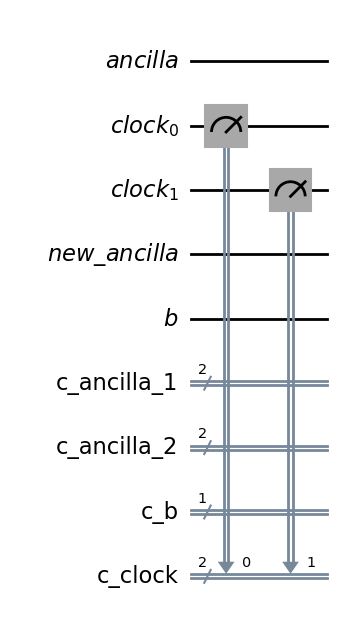

<Figure size 1600x800 with 0 Axes>

In [21]:
fig = plt.figure(figsize=(16, 8))
# ax = fig.add_subplot()
height = 0.8
hhl.draw('mpl', fold=1)
# fig = hhl.draw("mpl")
# fig.savefig('defense_c.pdf', bbox_inches='tight')

In [80]:
# nShots = 10000
# # hhl_tr = transpile(hhl, backend, layout_method='trivial', optimization_level=0)
# hhl_tr = transpile(hhl, backend, initial_layout=initial_layout, optimization_level=0)
# # hhl_tr.draw(output='mpl', idle_wires=False)

In [85]:
# job = backend.run([hhl_tr], 
#                   meas_level=2, 
#                   meas_return='single', 
#                   shots=nShots)
# job.job_id()

In [75]:
# job_id = "cv8bhw7qrk1g008r06wg"
# job = service.job(job_id)
# job_monitor(job)

In [173]:
###### all defenses, 10000 shots, [0, 1, 2, 14, 3], ancilla, clock, new_ancilla, b
# job_id = "cvb2a30qq7s000885t90"
# job_id = "cvb2e48a1h6g008ak29g"
job_id = "cvb2a70qq7s000885t9g"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["00 1 01 00"]/counts["00 0 01 00"])
# fig=plot_histogram(counts)
# fig.savefig('all_defenses_3.png', bbox_inches='tight')
# plot_histogram(counts)

1.1872246696035242


In [9]:
###### defense for b, 10000 shots, b=1, [0, 1, 14, 2, 3], b, clock, ancilla, new_ancilla
# job_id = "cvb1dgp3nf7g008j6h8g"
# job_id = "cvb1djea1h6g008ajzvg"
job_id = "cvb1dme9y050008fsf0g"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 1 00"]/counts["0 1 00"])
# fig=plot_histogram(counts)
# fig.savefig('defense_b_b=1_1.png', bbox_inches='tight')
# plot_histogram(counts)

1.608695652173913


In [11]:
###### defense for b, 10000 shots, higher energy, [0, 1, 14, 2, 3], b, ancilla, clock, new_ancilla
job_id = "cvb1bsfz4vvg00879ge0"
# job_id = "cvb1c70qq7s000885qsg"
# job_id = "cvb1ca19y050008fsex0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 1 00"]/counts["0 1 00"])
fig=plot_histogram(counts)
# fig.savefig('defense_b_higher_energy_3.png', bbox_inches='tight')
# plot_histogram(counts)

5.421621621621622


In [13]:
###### defense for b, 10000 shots, no attack, [0, 1, 14, 2, 3], b, ancilla, clock, new_ancilla
# job_id = "cvb18hj9y050008fsek0"
# job_id = "cvb18ntz4vvg00879g50"
job_id = "cvb1fkpa1h6g008ak05g"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 1 00"]/counts["0 1 00"])
fig=plot_histogram(counts)
# fig.savefig('defense_b_no_attack_1.png', bbox_inches='tight')
# plot_histogram(counts)

1.0738603577611079


In [61]:
###### defense for c0=2, 10000 shots, correct transpilation
# job_id = "cw87hq6ggr6g0087mbqg"
# job_id = "cw87hpp2802g0081fqcg"
job_id = "cw87hnyjyrs0008gt6wg"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["0 11"]/counts["0 01"])
# plot_histogram(counts, filename='defense_c0_higher_energy_3.png')

0.9860724233983287


In [65]:
###### defense for c0=1, 10000 shots, correct transpilation
job_id = "cw87mf9ggr6g0087mby0"
# job_id = "cw87mesjzdhg008eawag"
# job_id = "cw87me9jzdhg008eawa0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["0 11"]/counts["0 01"])
# plot_histogram(counts, filename='defense_c0_c0=1_3.png')

1.9164222873900294


In [88]:
###### defense for c1=2, 10000 shots, correct transpilation
job_id = "cw8jfcdggr6g0087p29g"
# job_id = "cw8jfdd9ezk000811ah0"
# job_id = "cw8jfe5jzdhg008ecjsg"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["0 11"]/counts["0 01"])
# plot_histogram(counts, filename='defense_c1_c1=1_3.png')

0.6875


In [91]:
###### defense for c1=1, 10000 shots, correct transpilation
# job_id = "cw8jja12802g0081hdv0"
# job_id = "cw8jj9hggr6g0087p2t0"
job_id = "cw8jj8s9ezk000811b90"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["0 11"]/counts["0 01"])
# plot_histogram(counts, filename='defense_c1_higher_energy_3.png')

1.0581257413997627


In [ ]:
###### defense for ancilla=2, 10000 shots, correct transpilation
# job_id = "cv7kb8dqrk1g008qy8wg"
# job_id = "cv7kbax8gpc0008gchrg"
job_id = "cv7m70w8gpc0008gcn6g"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
# plot_histogram(counts, filename='defense_c0_c0=1_3.png')

1.0783537791848041


In [17]:
# ####### defense for ancilla=1, 10000 shots, correct transpilation
# job_id = "cv7medh8gpc0008gcnm0"
# job_id = "cv7mefsemvv00084x44g"
job_id = "cv8bhw7qrk1g008r06wg"
# job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
# plot_histogram(counts, filename='defense_a_a=1_3.png')

1.0783537791848041


In [21]:
####### defense for new_ancilla=2, 10000 shots, correct transpilation
# job_id = "cvb0zzzqq7s000885pb0"
# job_id = "cvb11k6v9wwg008wk6m0"
job_id = "cvb1218v9wwg008wk6pg"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
# plot_histogram(counts, filename='defense_a_newa_higher_energy_3.png')

1.300751879699248


In [23]:
####### defense for new_ancilla = 1, 10000 shots, correct transpilation
job_id = "cvb0y0g3nf7g008s6wsg"
# job_id = "cvb13my3nf7g008s6x6g"
# job_id = "cvb13qez4vvg00879fv0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
# plot_histogram(counts, filename='defense_a_newa=1_3.png')

0.9477911646586346


In [33]:
####### only defense, no attack, 10000 shots, correct transpilation
# job_id = "cvb06wva1h6g0089r240"
# job_id = "cvb070w3nf7g008s6sgg"
job_id = "cvb0754v9wwg0080sb90"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
# plot_histogram(counts, filename='defense_a_no_attack_3.png')

1.151303242212333


In [24]:
### defense for new_ancilla = 2

#job_id='cv554s3hdzz0008m2p70'
#job_id='cv5552mx55b0008qwe3g'
#job_id='cv5558dx55b0008qwe5g'

In [25]:
# ##### defense for higher energy, correct transpilation
# job_id = 'cv5wnsqx55b0008qyqsg'
# job_id = 'cv5wp08x55b0008qyqvg'
# job_id = 'cv5wp20fkm5g008bxgz0'

In [26]:
# ## defense for higher energy, wrong !!
# job_id = 'cv3prc9hdzz0008vzwy0'
# job_id = 'ctztx6cg9ymg0081ed20'

In [27]:
# ## defense for 1
# job_id = 'cv3nq9nfkm5g008mwpag'
# job_id = 'ctztzsqqtch000891710'

In [28]:
# ## defense with no attack
# job_id = 'cv3npch1vt8g0089pdd0'
# job_id = 'ctzvhqpcn2b00081fjk0'
# job_id = 'cv5wre9qxmm00085ft30'

In [29]:
##### no defense, no attack
#job_id = 'cv5wte9fkm5g008bxj10'

In [30]:
# job = service.job(job_id)
# job_monitor(job)

In [16]:
# ####### no defense, no attack, 10000 shots
# ### job_id = "cv5wte9fkm5g008bxj10" ####### 1000 shots
job_id = "cv7k8q2kfn8g008vm09g"
# job_id = "cv6z8mjkwkwg00873n00"
# job_id = "cv6z9kyt5n500084x3pg"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
# plot_histogram(counts, filename='defense_a_no_defense_no_attack_3.png')

1.2124866974104291


1.2957198443579767


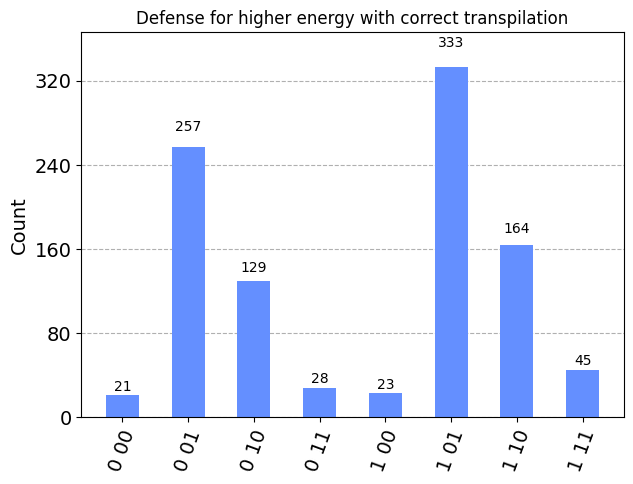

In [69]:
job_id = "cv5wp20fkm5g008bxgz0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
plot_histogram(counts, title='Defense for higher energy with correct transpilation 1000 shots')

1.3991596638655461


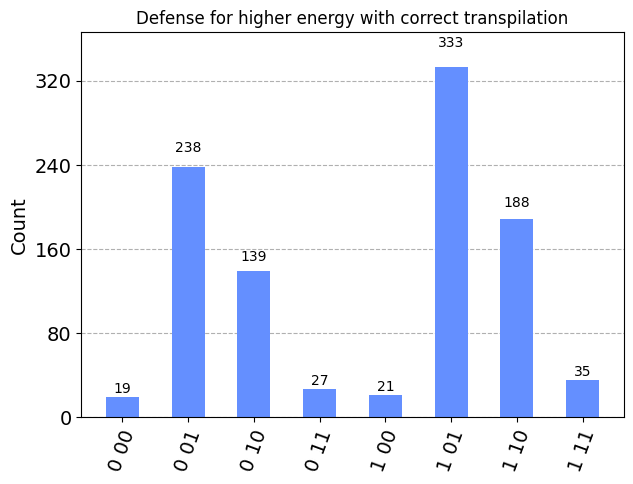

In [70]:
job_id = "cv5wp08x55b0008qyqvg"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
plot_histogram(counts, title='Defense for higher energy with correct transpilation')

1.3702127659574468


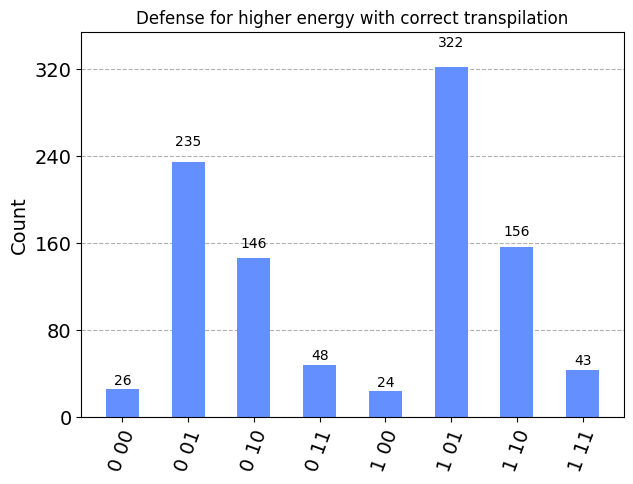

In [71]:
job_id = "cv5wnsqx55b0008qyqsg"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
plot_histogram(counts, title='Defense for higher energy with correct transpilation')

1.2


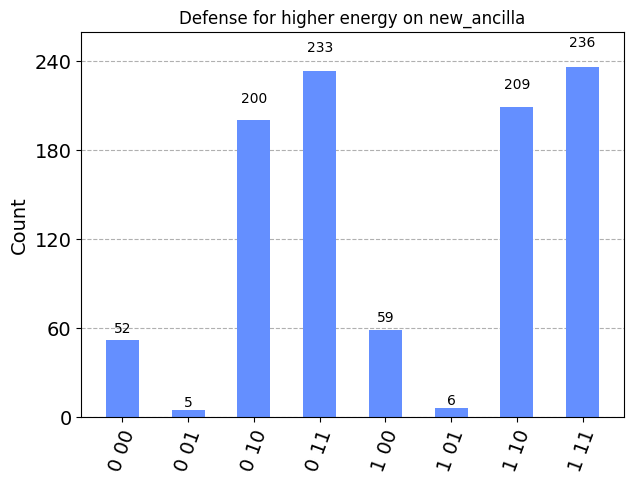

In [72]:
job_id = "cv5558dx55b0008qwe5g"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
plot_histogram(counts, title='Defense for higher energy on new_ancilla')

1.0


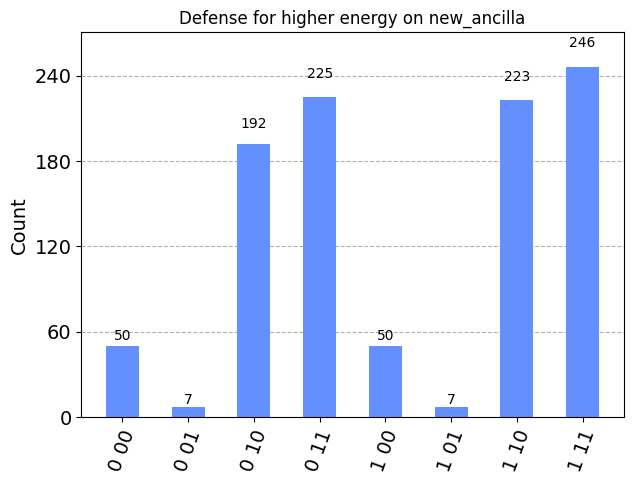

In [73]:
job_id = "cv5552mx55b0008qwe3g"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
plot_histogram(counts, title='Defense for higher energy on new_ancilla')

1.0


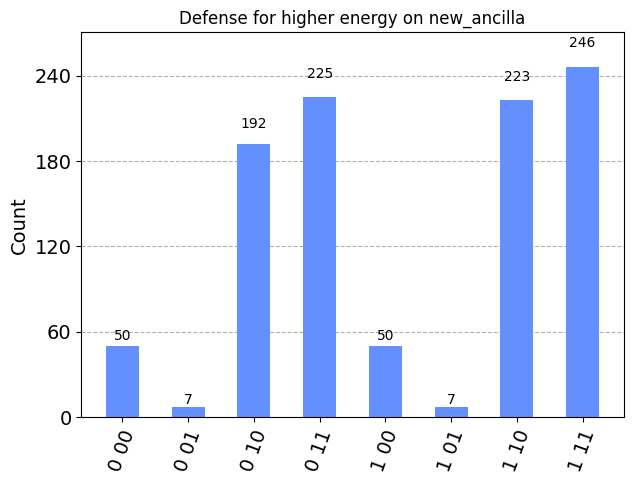

In [74]:
job_id = "cv5552mx55b0008qwe3g"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
plot_histogram(counts, title='Defense for higher energy on new_ancilla')

0.7


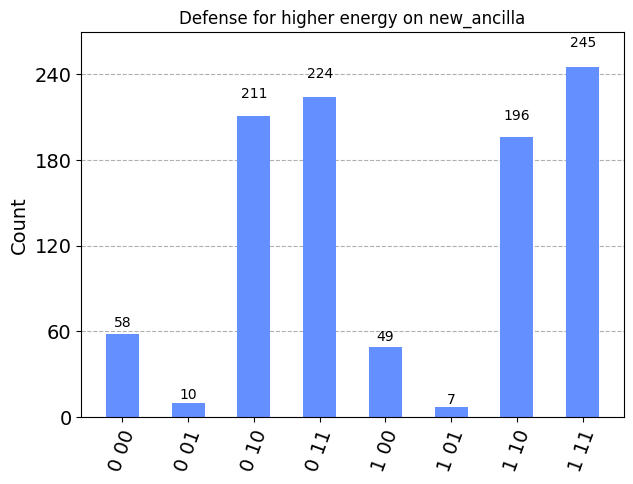

In [75]:
job_id = "cv554s3hdzz0008m2p70"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
plot_histogram(counts, title='Defense for higher energy on new_ancilla')

0.9318181818181818


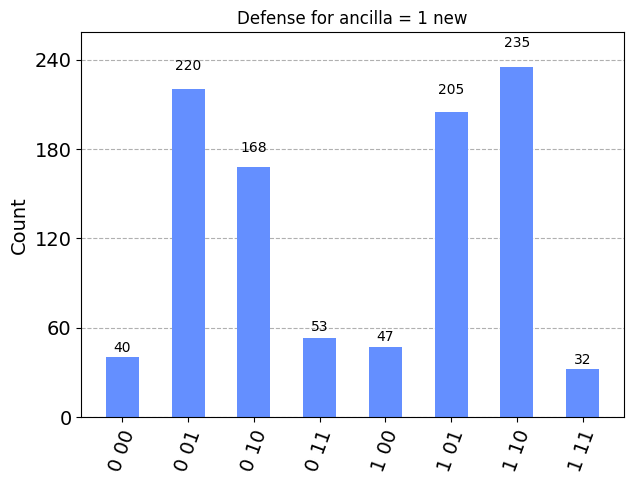

In [76]:
job_id = "cv3nq9nfkm5g008mwpag"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
plot_histogram(counts, title='Defense for ancilla = 1 new')

1.2820512820512822


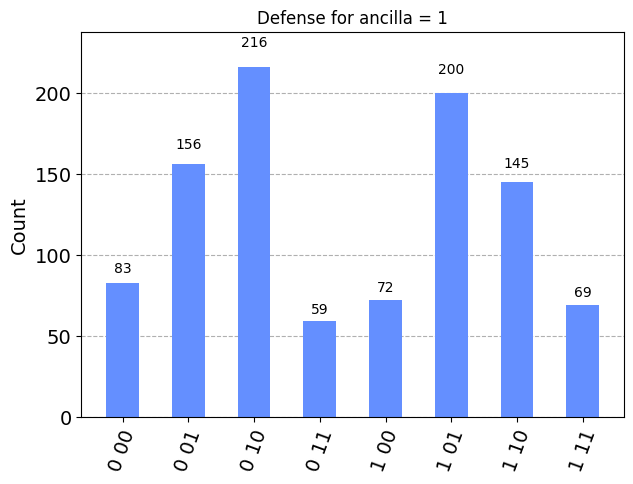

In [77]:
job_id = "ctztzsqqtch000891710"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
plot_histogram(counts, title='Defense for ancilla = 1')

0.6938775510204082


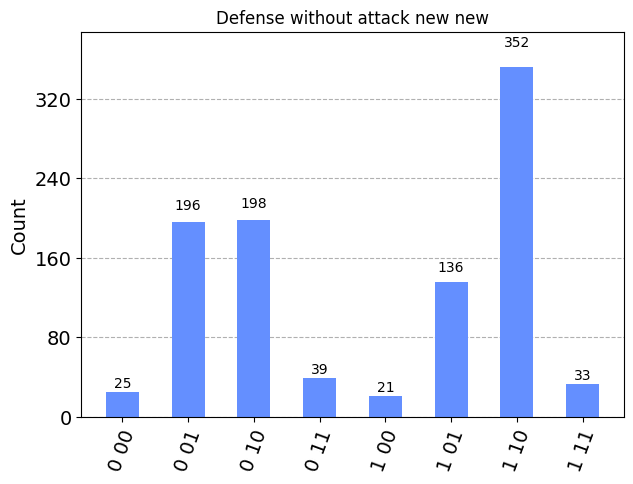

In [78]:
job_id = "cv5wre9qxmm00085ft30"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
plot_histogram(counts, title='Defense without attack new new')

0.6807692307692308


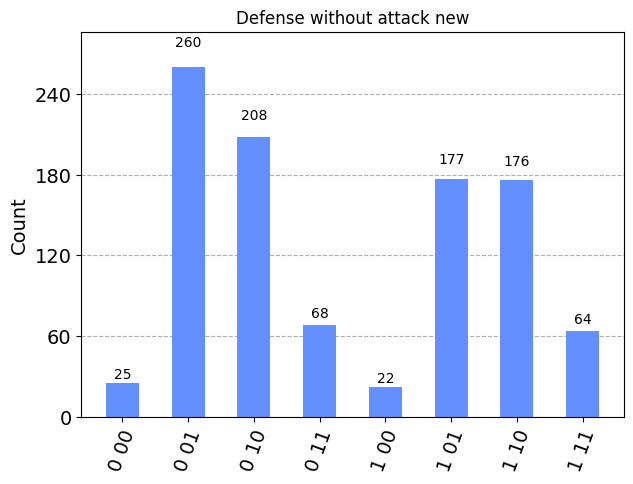

In [79]:
job_id = "cv3npch1vt8g0089pdd0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
plot_histogram(counts, title='Defense without attack new')

0.8681318681318682


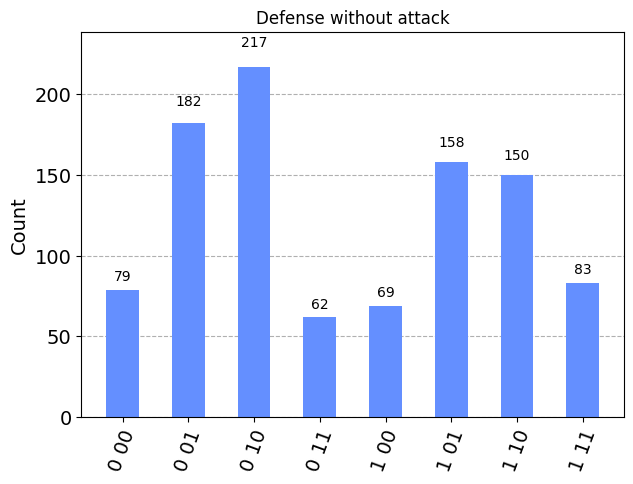

In [80]:
job_id = "ctzvhqpcn2b00081fjk0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(counts["1 01"]/counts["0 01"])
plot_histogram(counts, title='Defense without attack')